In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math

In [2]:
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size, padding=(kernel_size // 2), bias=bias
    )

In [3]:
class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.weight.data.div_(std.view(3, 1, 1, 1))
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

In [ ]:
class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):
        m = []
        if (scale & (scale - 1)) == 0:  # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn:
                    m.append(nn.BatchNorm2d(n_feat))
                if act:
                    m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn:
                m.append(nn.BatchNorm2d(n_feat))
            if act:
                m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)

In [4]:
## Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

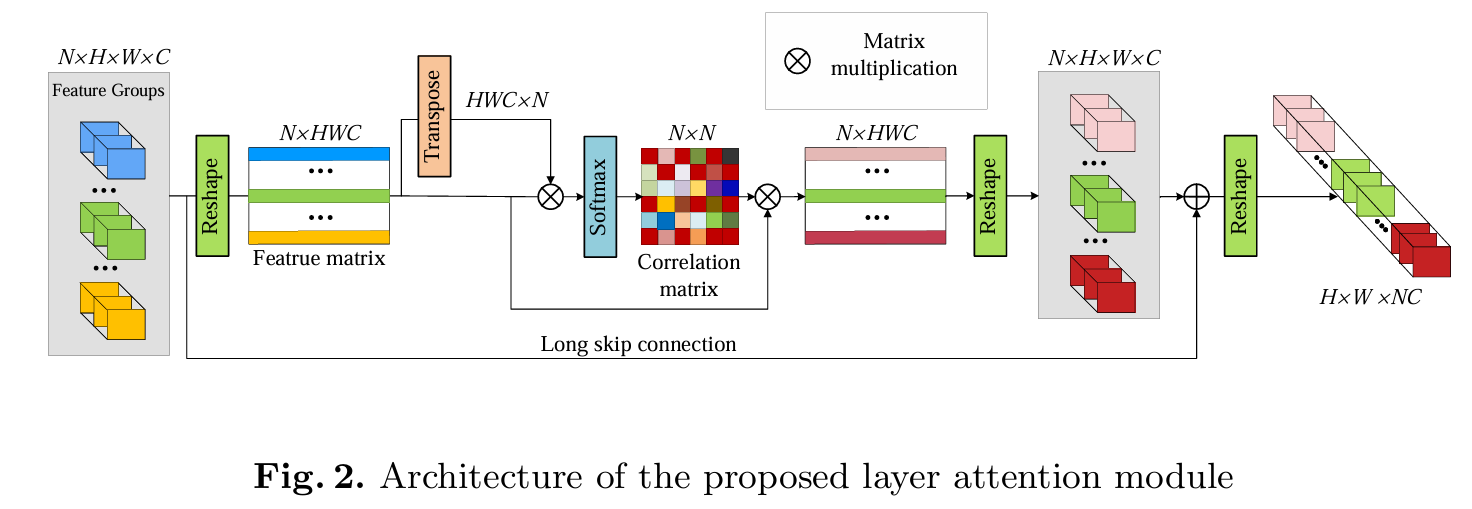

In [13]:
class LAM_Module(nn.Module):
    """Layer attention module"""

    def __init__(self, in_dim) -> None:
        super().__init__()
        self.channel_in = in_dim

        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        """
        inputs :
            x : input feature maps( B X N X C X H X W)
        returns :
            out : attention value + input feature
            attention: B X N X N
        """
        m_batchsize, N, C, height, width = x.size()
        proj_query = x.view(m_batchsize, N, -1)
        print(f"proj_query : {proj_query.size()}")
        proj_key = x.view(m_batchsize, N, -1).permute(0, 2, 1)
        print(f"proj_key : {proj_key.size()}")

        energy = torch.bmm(proj_query, proj_key)
        print(f"energy : {energy.size()}")
        print(f"max size : {torch.max(energy, -1, keepdim=True)[0].size()}")
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy) - energy
        print(f"energy_new size : {energy_new.size()}")
        attention = self.softmax(energy_new)
        proj_value = x.view(m_batchsize, N, -1)

        out = torch.bmm(attention, proj_value)
        print(f"out1 size : {out.size()}")
        out = out.view(m_batchsize, N, C, height, width)
        print(f"out2 size : {out.size()}")

        out = self.gamma * out + x
        out = out.view(m_batchsize, -1, height, width)
        print(f"out3 size : {out.size()}")
        return out

In [14]:
model = LAM_Module(1)
x = torch.randn(16, 8, 4, 5, 6)
y = model(x)

proj_query : torch.Size([16, 8, 120])
proj_key : torch.Size([16, 120, 8])
energy : torch.Size([16, 8, 8])
max size : torch.Size([16, 8, 1])
energy_new size : torch.Size([16, 8, 8])
out1 size : torch.Size([16, 8, 120])
out2 size : torch.Size([16, 8, 4, 5, 6])
out3 size : torch.Size([16, 32, 5, 6])


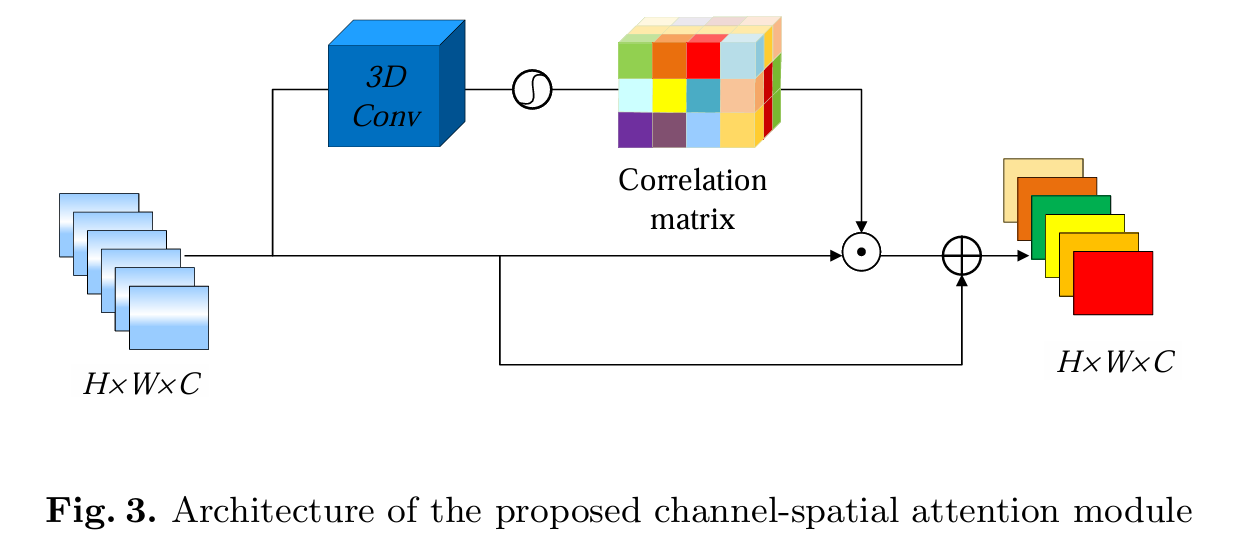

In [21]:
class CSAM_Module(nn.Module):
    """Channel-Spatial attention module"""

    def __init__(self, in_dim) -> None:
        super().__init__()

        self.channel_in = in_dim

        self.conv = nn.Conv3d(
            in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1
        )
        self.gamma = nn.Parameter(torch.zeros(1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        m_batchsize, C, height, width = x.size()
        out = x.unsqueeze(1)
        print(f'out1 size : {out.size()}')
        out = self.sigmoid(self.conv(out))
        print(f'out2 size : {out.size()}')
        out = self.gamma * out
        out = out.view(m_batchsize, -1, height, width)
        print(f'out3 size : {out.size()}')
        x = out * x + x
        return x

In [22]:
conv = nn.Conv3d(in_channels=2, out_channels=5, kernel_size=3, stride=1, padding=1)
print(f'conv weight size :{conv.weight.size()}')

model = CSAM_Module(1)
x = torch.randn(16, 8, 5, 6)
y = model(x)

conv weight size :torch.Size([5, 2, 3, 3, 3])
out1 size : torch.Size([16, 1, 8, 5, 6])
out2 size : torch.Size([16, 1, 8, 5, 6])
out3 size : torch.Size([16, 8, 5, 6])


In [23]:
## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(
        self,
        conv,
        n_feat,
        kernel_size,
        reduction,
        bias=True,
        bn=False,
        act=nn.ReLU(True),
        res_scale=1,
    ):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn:
                modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0:
                modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        # res = self.body(x).mul(self.res_scale)
        res += x
        return res

In [25]:
## Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks
    ):
        super(ResidualGroup, self).__init__()
        modules_body = []
        modules_body = [
            RCAB(
                conv,
                n_feat,
                kernel_size,
                reduction,
                bias=True,
                bn=False,
                act=nn.ReLU(True),
                res_scale=1,
            )
            for _ in range(n_resblocks)
        ]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

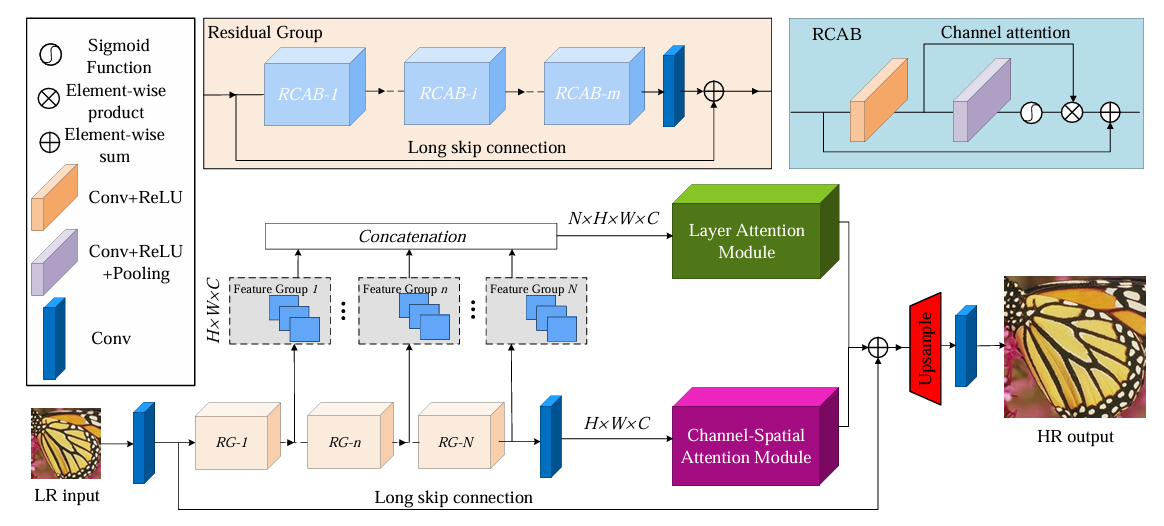

In [ ]:
# Holistic Attention Network
class HAN(nn.Module):
    def __init__(self, args, conv=default_conv) -> None:
        super().__init__()
        n_resgroups = args.n_resgroups
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        reduction = args.reduction
        scale = args.scale[0]
        act = nn.ReLU(True)

        # RGB mean for DIV2K
        rgb_mean = (0.4488, 0.4371, 0.4040)
        rgb_std = (1.0, 1.0, 1.0)
        self.sub_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std)

        # define head module
        modules_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        modules_body = [
            ResidualGroup(
                conv,
                n_feats,
                kernel_size,
                reduction,
                act=act,
                res_scale=args.res_scale,
                n_resblocks=n_resblocks,
            )
            for _ in range(n_resgroups)
        ]
        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, args.n_colors, kernel_size),
        ]

        self.add_mean = MeanShift(args.rgb_range, rgb_mean, rgb_std, 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.csa = CSAM_Module(n_feats)
        self.la = LAM_Module(n_feats)
        self.last_conv = nn.Conv2d(n_feats * 11, n_feats, 3, 1, 1)
        self.last = nn.Conv2d(n_feats * 2, n_feats, 3, 1, 1)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)
        res = x
        for name, midlayer in self.body._modules.items():
            res = midlayer(res)
            if name == "0":
                resl = res.unsqueeze(1)
            else:
                resl = torch.cat([res.unsqueeze(1), resl], 1)
        out1 = res

        res = self.la(resl)
        out2 = self.last_conv(res)

        out1 = self.cas(out1)
        out = torch.cat([out1, out2], 1)
        res = self.last(out)

        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x